In [11]:
import os
import numpy as np
import pickle
import datetime
from time import gmtime, strftime
import pandas as pd
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


## Loading Model and Preprocessed Test Data

In [16]:
data_dir = 'input_data'
model_dir = 'models'
pred_dir = 'predictions'
model_name = 'XGB-model-pca-07-17-20'
seed=0

#Creating prediction directory
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

In [17]:
def load_model(model_name):
    if model_name[0:3] == 'XGB': 
        import sagemaker
        from sagemaker import get_execution_role
        from sagemaker.amazon.amazon_estimator import get_image_uri
        sagemaker_session = sagemaker.Session()
        bucket = sagemaker_session.default_bucket()
        role = sagemaker.get_execution_role()
        model_prefix = 'santander_project/XGBoost'
        
        container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')
        model_artifacts = sagemaker_session.upload_data(os.path.join(model_dir, model_name), bucket=bucket, key_prefix=model_prefix)
        
        primary_container = {
            "Image": container,
            "ModelDataUrl": model_artifacts
         }
        
        loaded_model = sagemaker_session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)
        return loaded_model
    
    else:   
        loaded_model = pickle.load(open(os.path.join(model_dir, model_name), 'rb'))
        return loaded_model

In [49]:
def make_predictions(model_name, transform='pca', sagemaker_model=True, transform_target=True):
    files_dict = {'sparse' : 'test_sparse_pca.csv', 'pca' : 'test_pca.csv', 'imputation' : 'test_imputed.csv', None : 'test.csv'}
    global data_dir 
    global pred_dir
    loaded_model = load_model(model_name)
    
    if sagemaker_model==True:
            import re
            import sagemaker
            sagemaker_session = sagemaker.Session()
 
            transform_job_name = model_name + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

            transform_request = \
            {
                "TransformJobName": transform_job_name,

                "ModelName": model_name,

                "MaxConcurrentTransforms": 1,

                "MaxPayloadInMB": 6,

                "BatchStrategy": "MultiRecord",

                "TransformOutput": {
                    "S3OutputPath": "s3://{}/santander_project/XGBoost/batch-bransform/".format(sagemaker_session.default_bucket()),
                    'Accept' : 'text/csv',
                    'AssembleWith' : 'Line'
                },

                "TransformInput": {
                    "ContentType": "text/csv",
                    "SplitType": "Line",
                    "DataSource": {
                        "S3DataSource": {
                            "S3DataType": "S3Prefix",
                            "S3Uri": 's3://{}/santander_project/data/{}'.format(sagemaker_session.default_bucket(), files_dict[transform])
                        }
                    }
                },

                "TransformResources": {
                        "InstanceType": "ml.m4.xlarge",
                        "InstanceCount": 1
                },
                
                "DataProcessing": { 
                        "InputFilter":  '$', 
                        "JoinSource": "Input",
                        "OutputFilter": "$[-1:]"    
                }
            }
            
            transform_response = sagemaker_session.sagemaker_client.create_transform_job(**transform_request)
            transform_desc = sagemaker_session.wait_for_transform_job(transform_job_name)
            transform_location = transform_request['TransformOutput']['S3OutputPath'] 
            
            # Saving predictions from s3 to local drive
            !aws s3 cp --recursive $transform_location $pred_dir 
            predictions_file = [x for x in os.listdir(pred_dir)][0]
            predictions = pd.read_csv(os.path.join(pred_dir, predictions_file), header=None, engine='python')
            
            # Inverting Box-Cox transformation of target variable, if applicable
            if transform_target==True:
                predictions = special.inv_boxcox(predictions.values, stats.boxcox(pd.read_csv(os.path.join(data_dir, 'train.csv'), usecols=['target', 'ID'], index_col='ID')['target'])[1])
                predictions = [x[0] for x in predictions]
                return predictions
            else: 
                return predictions
            
    else:
        X_test = pd.read_csv(os.path.join(data_dir, files_dict[transform]))
        predictions = loaded_model.predict(X_test)
        
        # Inverting Box-Cox transformation of target variable, if applicable
        if transform_target==True:
            predictions = special.inv_boxcox(predictions.reshape(-1, 1), stats.boxcox(pd.read_csv(os.path.join(data_dir, 'train.csv'), usecols=['target', 'ID'], index_col='ID')['target'])[1])
            predictions = [x[0] for x in predictions]
            return predictions
        else:
            return predictions

In [50]:
predictions = make_predictions(model_name)

	get_image_uri(region, 'xgboost', '1.0-1').


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Cannot create already existing model "arn:aws:sagemaker:us-east-2:278383315865:model/xgb-model-pca-07-17-20".

## Making Predictions on Test Data

Inverting the Box-Cox transformation on the predictions using the original lambda derived from training data, for comparison to the true target values

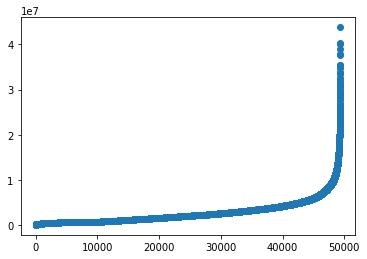

In [43]:
plt.scatter(range(len(predictions)), np.sort(predictions))

Well.... thats not great. 

Saving predictions for submission

In [ ]:
time = datetime.datetime.now().strftime("%D").replace('/', '_')


submission = pd.Series(predictions, X_test.index, name='target')
    
pred_file = 'predictions_{}.csv'.format(time)
submission.to_csv(os.path.join(pred_dir, pred_file))